In [ ]:
import os
from pathlib import Path
import builtins
import json
import pandas as pd
import shutil

# 1. Mount Google Drive (if not already)
from google.colab import drive
if not os.path.exists('/content/drive'):
    print("Mounting Google Drive...")
    drive.mount('/content/drive')
    print("Google Drive mounted!")
else:
    print("Google Drive already mounted.")

# 2. Define base project directory on Drive (change if needed)
BASE_DIR = Path("/content/drive/MyDrive/intelligent_pesticide_system")

# 3. Change working directory to project root (optional)
os.chdir(str(BASE_DIR))
print(f"Working directory set to project root: {os.getcwd()}")

# 4. Patch built-in open() to redirect file paths under BASE_DIR automatically,
#    unless absolute path already points to BASE_DIR or special paths.

original_open = builtins.open

def patched_open(file, mode='r', buffering=-1, encoding=None,
                 errors=None, newline=None, closefd=True, opener=None):
    fpath = file
    if isinstance(file, str):
        if not (file.startswith(str(BASE_DIR)) or os.path.isabs(file)):
            # Redirect relative paths inside BASE_DIR
            fpath = BASE_DIR / file
    elif isinstance(file, Path):
        if not file.is_absolute():
            fpath = BASE_DIR / file
        else:
            fpath = file
    else:
        fpath = file  # If not str or Path, keep as is

    # Ensure parent directories exist for writing
    if 'w' in mode or 'a' in mode or 'x' in mode:
        os.makedirs(Path(fpath).parent, exist_ok=True)

    return original_open(fpath, mode, buffering, encoding, errors, newline, closefd, opener)

builtins.open = patched_open

# 5. Patch pandas read_csv and to_csv similarly

original_read_csv = pd.read_csv
def patched_read_csv(filepath_or_buffer, *args, **kwargs):
    if isinstance(filepath_or_buffer, str):
        if not filepath_or_buffer.startswith(str(BASE_DIR)):
            filepath_or_buffer = str(BASE_DIR / filepath_or_buffer)
    return original_read_csv(filepath_or_buffer, *args, **kwargs)
pd.read_csv = patched_read_csv

original_to_csv = pd.DataFrame.to_csv
def patched_to_csv(self, path_or_buf=None, *args, **kwargs):
    if isinstance(path_or_buf, str) and not path_or_buf.startswith(str(BASE_DIR)):
        path_or_buf = str(BASE_DIR / path_or_buf)
    os.makedirs(Path(path_or_buf).parent, exist_ok=True)
    return original_to_csv(self, path_or_buf, *args, **kwargs)
pd.DataFrame.to_csv = patched_to_csv

# 6. Patch torch.save similarly if using PyTorch

try:
    import torch

    original_torch_save = torch.save

    def patched_torch_save(obj, f, *args, **kwargs):
        if isinstance(f, str):
            if not f.startswith(str(BASE_DIR)):
                f = str(BASE_DIR / f)
            os.makedirs(Path(f).parent, exist_ok=True)
        return original_torch_save(obj, f, *args, **kwargs)

    torch.save = patched_torch_save
except ImportError:
    print("PyTorch not installed, skipping torch.save patch")

# 7. Patch matplotlib.pyplot.savefig to save inside the project folder automatically

import matplotlib.pyplot as plt
original_savefig = plt.savefig

def patched_savefig(fname, *args, **kwargs):
    if isinstance(fname, str):
        if not fname.startswith(str(BASE_DIR)):
            fname = str(BASE_DIR / fname)
        os.makedirs(Path(fname).parent, exist_ok=True)
    return original_savefig(fname, *args, **kwargs)

plt.savefig = patched_savefig

print("Universal drive path redirection is active. All file reads/writes go to your Drive folder!")


Mounting Google Drive...
Mounted at /content/drive
Google Drive mounted!
Working directory set to project root: /content/drive/MyDrive/intelligent_pesticide_system
Universal drive path redirection is active. All file reads/writes go to your Drive folder!


In [ ]:
import os
import json
import pandas as pd
import numpy as np
from pathlib import Path
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import shutil
from sklearn.model_selection import train_test_split

# Load configuration
current_dir = Path.cwd()
if current_dir.name == 'notebooks':
    BASE_DIR = current_dir.parent
    NOTEBOOKS_DIR = current_dir
else:
    BASE_DIR = current_dir
    NOTEBOOKS_DIR = BASE_DIR / 'notebooks'

RAW_DATA_DIR = BASE_DIR / "data" / "raw"
PROCESSED_DATA_DIR = BASE_DIR / "data" / "processed"
METADATA_DIR = BASE_DIR / "data" / "metadata"

print("📋 UPDATED DATA PREPARATION")
print("=" * 60)
print(f"Base Directory: {BASE_DIR}")
print(f"Raw Data: {RAW_DATA_DIR}")
print(f"Processed Data: {PROCESSED_DATA_DIR}")

# Ensure directories exist
METADATA_DIR.mkdir(exist_ok=True)


📋 UPDATED DATA PREPARATION
Base Directory: /content/drive/MyDrive/intelligent_pesticide_system
Raw Data: /content/drive/MyDrive/intelligent_pesticide_system/data/raw
Processed Data: /content/drive/MyDrive/intelligent_pesticide_system/data/processed


In [ ]:
class PlantSegLoader:
    """Load PlantSeg dataset with existing train/val/test splits"""

    def __init__(self, plantseg_path):
        self.plantseg_path = Path(plantseg_path)
        self.images_dir = self.plantseg_path / "images"
        self.annotations_dir = self.plantseg_path / "annotations"

    def load_dataset_splits(self):
        """Load PlantSeg with existing splits"""
        datasets = {}

        for split in ['train', 'val', 'test']:
            print(f"Loading {split} data...")

            img_split_dir = self.images_dir / split
            ann_split_dir = self.annotations_dir / split

            if not img_split_dir.exists() or not ann_split_dir.exists():
                print(f"❌ {split} directory missing")
                continue

            # Get all image files
            image_files = list(img_split_dir.glob("*.jpg")) + list(img_split_dir.glob("*.jpeg"))

            split_data = []
            matched_pairs = 0

            for img_path in image_files:
                # Find corresponding mask
                mask_path = ann_split_dir / f"{img_path.stem}.png"

                if mask_path.exists():
                    # Extract disease type from filename
                    disease_type = img_path.name.split('_')[0] + '_' + img_path.name.split('_')[1]

                    split_data.append({
                        'image_path': str(img_path),
                        'mask_path': str(mask_path),
                        'disease_type': disease_type,
                        'filename': img_path.name,
                        'split': split,
                        'dataset': 'plantseg',
                        'task': 'segmentation'
                    })
                    matched_pairs += 1

            print(f"✅ {split}: {len(image_files)} images, {matched_pairs} with masks")
            datasets[split] = pd.DataFrame(split_data)

        return datasets

    def analyze_disease_types(self, datasets):
        """Analyze disease types in the dataset"""
        all_diseases = []

        for split, df in datasets.items():
            all_diseases.extend(df['disease_type'].tolist())

        disease_counts = pd.Series(all_diseases).value_counts()

        print(f"\n📊 DISEASE TYPES ANALYSIS:")
        print(disease_counts.head(10))

        return disease_counts

# Load PlantSeg dataset
print("🌱 LOADING PLANTSEG DATASET")
print("=" * 50)

plantseg_loader = PlantSegLoader(RAW_DATA_DIR / "plantseg")
plantseg_datasets = plantseg_loader.load_dataset_splits()

# Analyze disease types
disease_counts = plantseg_loader.analyze_disease_types(plantseg_datasets)

# Save PlantSeg data
for split, df in plantseg_datasets.items():
    df.to_csv(METADATA_DIR / f"plantseg_{split}.csv", index=False)
    print(f"💾 Saved plantseg_{split}.csv ({len(df)} samples)")


🌱 LOADING PLANTSEG DATASET
Loading train data...
✅ train: 7916 images, 7916 with masks
Loading val data...
✅ val: 1247 images, 1247 with masks
Loading test data...
✅ test: 2295 images, 2295 with masks

📊 DISEASE TYPES ANALYSIS:
citrus_canker     390
wheat_stripe      358
wheat_head        319
grape_downy       280
wheat_powdery     271
apple_scab        258
bell_pepper       247
soybean_frog      238
wheat_septoria    232
wheat_loose       215
Name: count, dtype: int64
💾 Saved plantseg_train.csv (7916 samples)
💾 Saved plantseg_val.csv (1247 samples)
💾 Saved plantseg_test.csv (2295 samples)


In [ ]:
class DiaMOSLoader:
    """Load DiaMOS dataset with CSV annotations"""

    def __init__(self, diamos_path):
        self.diamos_path = Path(diamos_path)
        self.csv_path = self.diamos_path / "annotation" / "csv" / "diaMOSPlant.csv"

    def load_csv_annotations(self):
        """Load DiaMOS CSV annotations"""
        print("📊 Loading DiaMOS CSV annotations...")

        if not self.csv_path.exists():
            print(f"❌ CSV file not found: {self.csv_path}")
            return None

        # Load CSV
        df = pd.read_csv(self.csv_path)
        print(f"✅ Loaded CSV with {len(df)} annotations")
        print(f"Columns: {list(df.columns)}")

        # Display first few rows to understand structure
        print("\n📋 FIRST 5 ROWS:")
        print(df.head())

        return df

    def create_severity_mapping(self, annotations_df):
        """Create severity classification dataset"""
        classification_data = []

        # Map DiaMOS categories to our severity levels
        severity_mapping = {
            'healthy': 0,      # none
            'curl': 1,         # mild
            'spot': 2,         # moderate
            'slug': 3          # severe
        }

        print(f"\n🎯 CREATING SEVERITY MAPPING:")
        for severity, code in severity_mapping.items():
            print(f"  {severity} → {code} ({['none', 'mild', 'moderate', 'severe'][code]})")

        # Process leaf images (main dataset)
        leaves_dir = self.diamos_path / "leaves"

        for category_dir in leaves_dir.iterdir():
            if category_dir.is_dir() and category_dir.name in severity_mapping:
                severity_code = severity_mapping[category_dir.name]
                severity_label = ['none', 'mild', 'moderate', 'severe'][severity_code]

                # Get all images in this category
                image_files = (
                    list(category_dir.glob("*.jpg")) +
                    list(category_dir.glob("*.jpeg")) +
                    list(category_dir.glob("*.png"))
                )

                # Filter out system files (._files)
                valid_images = [f for f in image_files if not f.name.startswith('._')]

                print(f"  📁 {category_dir.name}: {len(valid_images)} valid images")

                for img_path in valid_images:
                    classification_data.append({
                        'image_path': str(img_path),
                        'severity': severity_code,
                        'severity_label': severity_label,
                        'category': category_dir.name,
                        'filename': img_path.name,
                        'dataset': 'diamos',
                        'task': 'classification'
                    })

        return pd.DataFrame(classification_data)

    def create_train_val_test_splits(self, df, test_size=0.15, val_size=0.15, random_state=42):
        """Create stratified splits for classification"""
        # Stratified split to ensure balanced severity distribution
        train_val, test = train_test_split(
            df, test_size=test_size, random_state=random_state,
            stratify=df['severity']
        )

        train, val = train_test_split(
            train_val, test_size=val_size/(1-test_size), random_state=random_state,
            stratify=train_val['severity']
        )

        return train, val, test

# Load DiaMOS dataset
print("🍃 LOADING DIAMOS DATASET")
print("=" * 50)

diamos_loader = DiaMOSLoader(RAW_DATA_DIR / "diamos")

# Load CSV annotations
diamos_annotations = diamos_loader.load_csv_annotations()

# Create classification dataset
diamos_classification = diamos_loader.create_severity_mapping(diamos_annotations)

print(f"\n📈 DIAMOS CLASSIFICATION SUMMARY:")
severity_dist = diamos_classification['severity_label'].value_counts()
print(severity_dist)

# Create splits
diamos_train, diamos_val, diamos_test = diamos_loader.create_train_val_test_splits(diamos_classification)

print(f"\n📊 DIAMOS SPLITS:")
print(f"Train: {len(diamos_train)} samples")
print(f"Val: {len(diamos_val)} samples")
print(f"Test: {len(diamos_test)} samples")

# Save DiaMOS splits
diamos_train.to_csv(METADATA_DIR / "diamos_train.csv", index=False)
diamos_val.to_csv(METADATA_DIR / "diamos_val.csv", index=False)
diamos_test.to_csv(METADATA_DIR / "diamos_test.csv", index=False)

print("💾 DiaMOS datasets saved!")


🍃 LOADING DIAMOS DATASET
📊 Loading DiaMOS CSV annotations...
✅ Loaded CSV with 3005 annotations
Columns: ['filename;healthy;pear_slug;leaf_spot;curl;severity_0;severity_1;severity_2;severity_3;severity_4']

📋 FIRST 5 ROWS:
  filename;healthy;pear_slug;leaf_spot;curl;severity_0;severity_1;severity_2;severity_3;severity_4
0                           u2.jpg;0;0;1;0;0;1;0;0;0                                              
1                           u4.jpg;0;0;1;0;0;1;0;0;0                                              
2                           u6.jpg;0;0;1;0;0;1;0;0;0                                              
3                           u8.jpg;0;0;1;0;0;0;1;0;0                                              
4                          u10.jpg;0;0;1;0;0;1;0;0;0                                              

🎯 CREATING SEVERITY MAPPING:
  healthy → 0 (none)
  curl → 1 (mild)
  spot → 2 (moderate)
  slug → 3 (severe)
  📁 spot: 884 valid images
  📁 slug: 2025 valid images
  📁 healthy: 43 v

📊 COMPREHENSIVE DATASET ANALYSIS
🎯 DATASET SUMMARY:
Segmentation (PlantSeg): 11,458 samples
Classification (DiaMOS): 3,006 samples
Total dataset size: 14,464 samples


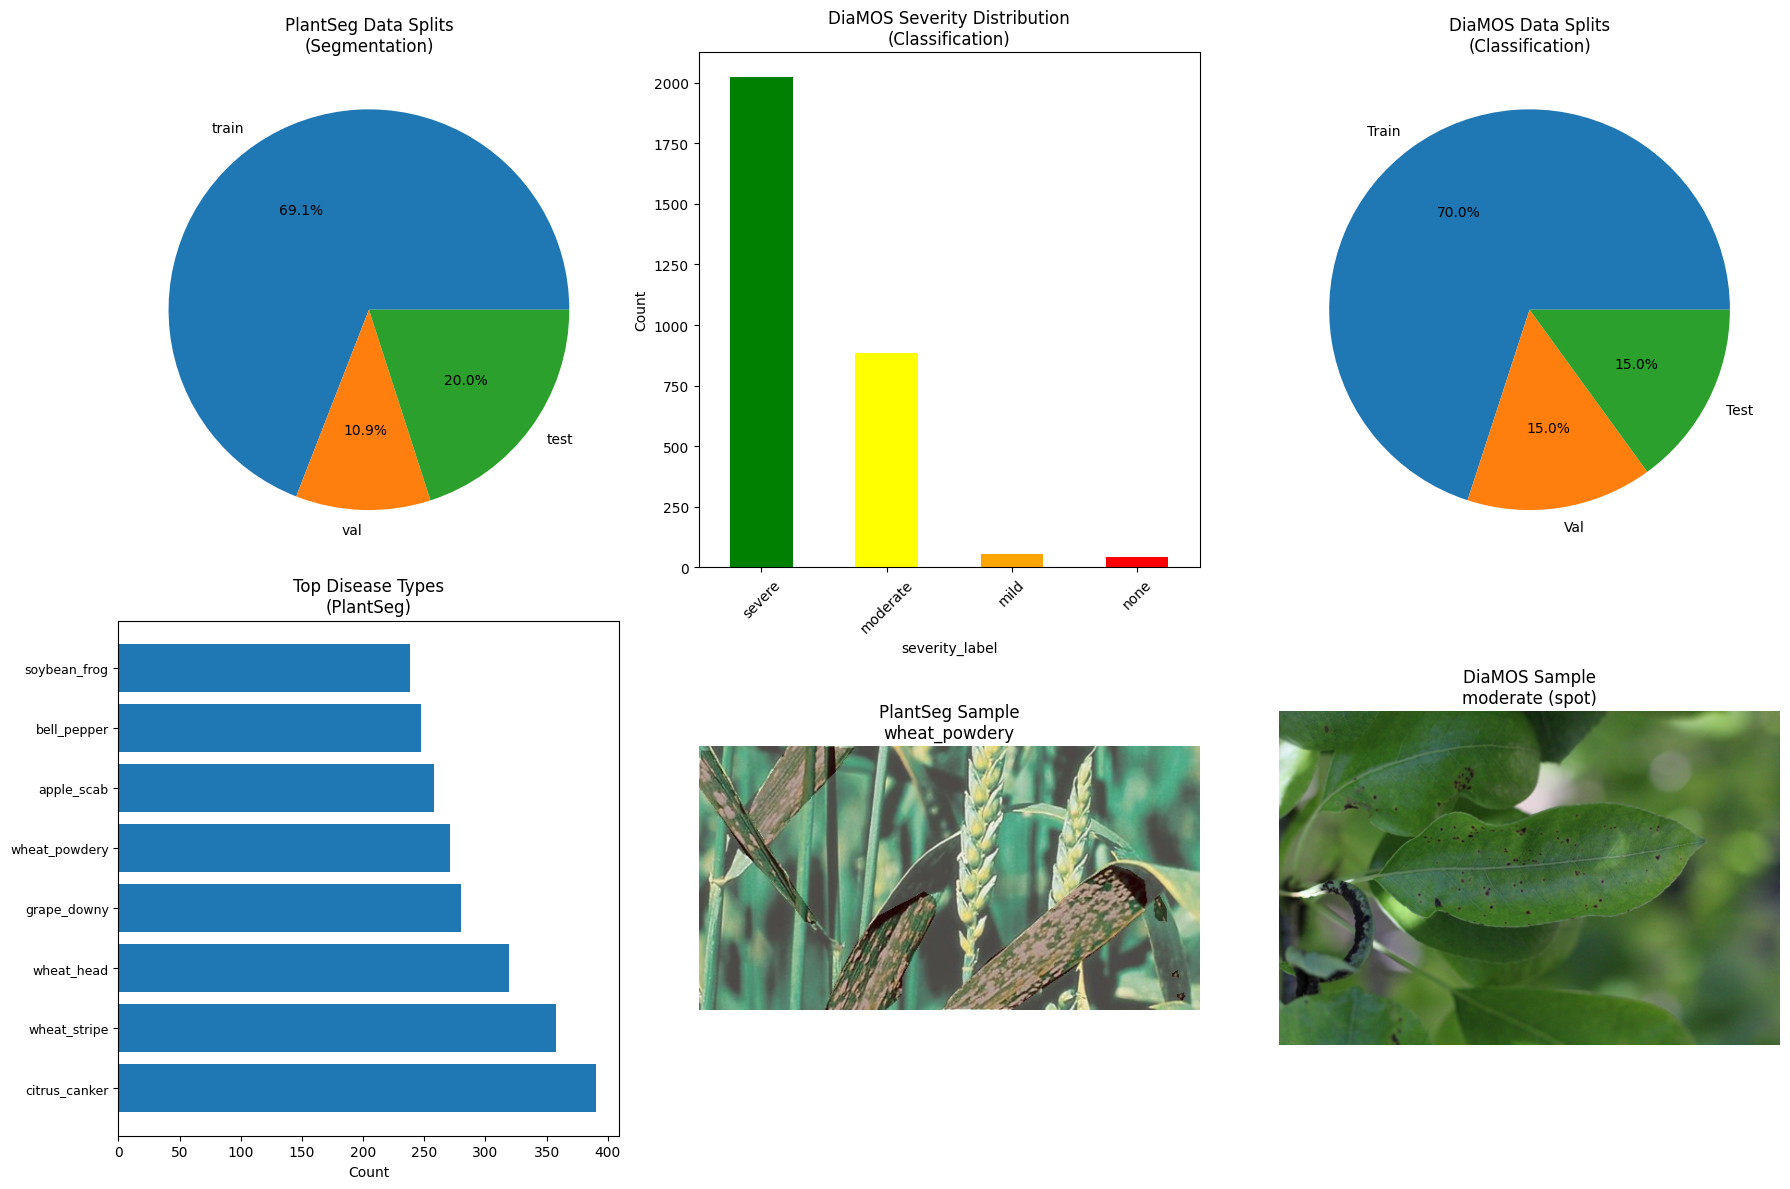

In [ ]:
# Comprehensive data analysis and visualization
print("📊 COMPREHENSIVE DATASET ANALYSIS")
print("=" * 60)

# Combined statistics
total_seg_samples = sum(len(df) for df in plantseg_datasets.values())
total_class_samples = len(diamos_classification)

print(f"🎯 DATASET SUMMARY:")
print(f"Segmentation (PlantSeg): {total_seg_samples:,} samples")
print(f"Classification (DiaMOS): {total_class_samples:,} samples")
print(f"Total dataset size: {total_seg_samples + total_class_samples:,} samples")

# Create comprehensive visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# PlantSeg split distribution
plantseg_split_counts = {split: len(df) for split, df in plantseg_datasets.items()}
axes[0, 0].pie(plantseg_split_counts.values(), labels=plantseg_split_counts.keys(), autopct='%1.1f%%')
axes[0, 0].set_title('PlantSeg Data Splits\n(Segmentation)')

# DiaMOS severity distribution
severity_dist.plot(kind='bar', ax=axes[0, 1], color=['green', 'yellow', 'orange', 'red'])
axes[0, 1].set_title('DiaMOS Severity Distribution\n(Classification)')
axes[0, 1].set_ylabel('Count')
axes[0, 1].tick_params(axis='x', rotation=45)

# DiaMOS split distribution
diamos_split_counts = {
    'Train': len(diamos_train),
    'Val': len(diamos_val),
    'Test': len(diamos_test)
}
axes[0, 2].pie(diamos_split_counts.values(), labels=diamos_split_counts.keys(), autopct='%1.1f%%')
axes[0, 2].set_title('DiaMOS Data Splits\n(Classification)')

# Top disease types from PlantSeg
top_diseases = disease_counts.head(8)
axes[1, 0].barh(range(len(top_diseases)), top_diseases.values)
axes[1, 0].set_yticks(range(len(top_diseases)))
axes[1, 0].set_yticklabels(top_diseases.index, fontsize=9)
axes[1, 0].set_title('Top Disease Types\n(PlantSeg)')
axes[1, 0].set_xlabel('Count')

# Sample images from each dataset
# PlantSeg sample
if len(plantseg_datasets['train']) > 0:
    sample_row = plantseg_datasets['train'].iloc[0]
    try:
        sample_img = cv2.imread(sample_row['image_path'])
        sample_mask = cv2.imread(sample_row['mask_path'], cv2.IMREAD_GRAYSCALE)

        if sample_img is not None and sample_mask is not None:
            sample_img_rgb = cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB)
            axes[1, 1].imshow(sample_img_rgb)
            axes[1, 1].imshow(sample_mask, alpha=0.3, cmap='Reds')
            axes[1, 1].set_title(f'PlantSeg Sample\n{sample_row["disease_type"]}')
            axes[1, 1].axis('off')
    except Exception as e:
        axes[1, 1].text(0.5, 0.5, f'Error loading\nPlantSeg sample:\n{str(e)[:50]}...',
                        ha='center', va='center', transform=axes[1, 1].transAxes)
        axes[1, 1].set_title('PlantSeg Sample (Error)')

# DiaMOS sample
if len(diamos_classification) > 0:
    sample_row = diamos_classification.iloc[0]
    try:
        sample_img = cv2.imread(sample_row['image_path'])
        if sample_img is not None:
            sample_img_rgb = cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB)
            axes[1, 2].imshow(sample_img_rgb)
            axes[1, 2].set_title(f'DiaMOS Sample\n{sample_row["severity_label"]} ({sample_row["category"]})')
            axes[1, 2].axis('off')
    except Exception as e:
        axes[1, 2].text(0.5, 0.5, f'Error loading\nDiaMOS sample:\n{str(e)[:50]}...',
                        ha='center', va='center', transform=axes[1, 2].transAxes)
        axes[1, 2].set_title('DiaMOS Sample (Error)')

plt.tight_layout()
plt.show()


In [ ]:
# Create integrated dataset for dual-branch training
print("🔧 CREATING INTEGRATED TRAINING DATASET")
print("=" * 60)

class IntegratedDatasetCreator:
    """Create unified dataset for dual-branch training"""

    def __init__(self, plantseg_datasets, diamos_splits):
        self.plantseg_datasets = plantseg_datasets
        self.diamos_train = diamos_splits[0]
        self.diamos_val = diamos_splits[1]
        self.diamos_test = diamos_splits[2]

    def create_integrated_splits(self):
        """Create integrated train/val/test splits"""

        integrated_splits = {}

        for split in ['train', 'val', 'test']:
            print(f"Creating integrated {split} dataset...")

            # Get PlantSeg data for this split
            plantseg_data = self.plantseg_datasets[split].copy()

            # Get DiaMOS data for this split
            if split == 'train':
                diamos_data = self.diamos_train.copy()
            elif split == 'val':
                diamos_data = self.diamos_val.copy()
            else:  # test
                diamos_data = self.diamos_test.copy()

            # Add task-specific flags
            plantseg_data['has_segmentation'] = True
            plantseg_data['has_classification'] = False
            plantseg_data['severity'] = -1  # No classification label
            plantseg_data['severity_label'] = 'unknown'

            diamos_data['has_segmentation'] = False
            diamos_data['has_classification'] = True
            diamos_data['mask_path'] = ''  # No segmentation mask
            diamos_data['disease_type'] = diamos_data['category']

            # Combine datasets
            integrated_data = pd.concat([plantseg_data, diamos_data], ignore_index=True)

            print(f"  ✅ {split}: {len(plantseg_data)} seg + {len(diamos_data)} class = {len(integrated_data)} total")

            integrated_splits[split] = integrated_data

        return integrated_splits

    def save_integrated_datasets(self, integrated_splits):
        """Save integrated datasets"""
        for split, df in integrated_splits.items():
            filename = METADATA_DIR / f"integrated_{split}.csv"
            df.to_csv(filename, index=False)
            print(f"💾 Saved {filename} ({len(df)} samples)")

# Create integrated datasets
creator = IntegratedDatasetCreator(
    plantseg_datasets,
    (diamos_train, diamos_val, diamos_test)
)

integrated_splits = creator.create_integrated_splits()
creator.save_integrated_datasets(integrated_splits)

# Summary statistics
print(f"\n📋 INTEGRATED DATASET SUMMARY:")
for split, df in integrated_splits.items():
    seg_count = (df['has_segmentation'] == True).sum()
    class_count = (df['has_classification'] == True).sum()
    print(f"{split.capitalize()}: {len(df)} total ({seg_count} seg, {class_count} class)")


🔧 CREATING INTEGRATED TRAINING DATASET
Creating integrated train dataset...
  ✅ train: 7916 seg + 2104 class = 10020 total
Creating integrated val dataset...
  ✅ val: 1247 seg + 451 class = 1698 total
Creating integrated test dataset...
  ✅ test: 2295 seg + 451 class = 2746 total
💾 Saved /content/drive/MyDrive/intelligent_pesticide_system/data/metadata/integrated_train.csv (10020 samples)
💾 Saved /content/drive/MyDrive/intelligent_pesticide_system/data/metadata/integrated_val.csv (1698 samples)
💾 Saved /content/drive/MyDrive/intelligent_pesticide_system/data/metadata/integrated_test.csv (2746 samples)

📋 INTEGRATED DATASET SUMMARY:
Train: 10020 total (7916 seg, 2104 class)
Val: 1698 total (1247 seg, 451 class)
Test: 2746 total (2295 seg, 451 class)


📈 COMPREHENSIVE DATASET SUMMARY
🎯 CLASSIFICATION DATA:
severity_label
severe      2025
moderate     884
mild          54
none          43
Name: count, dtype: int64


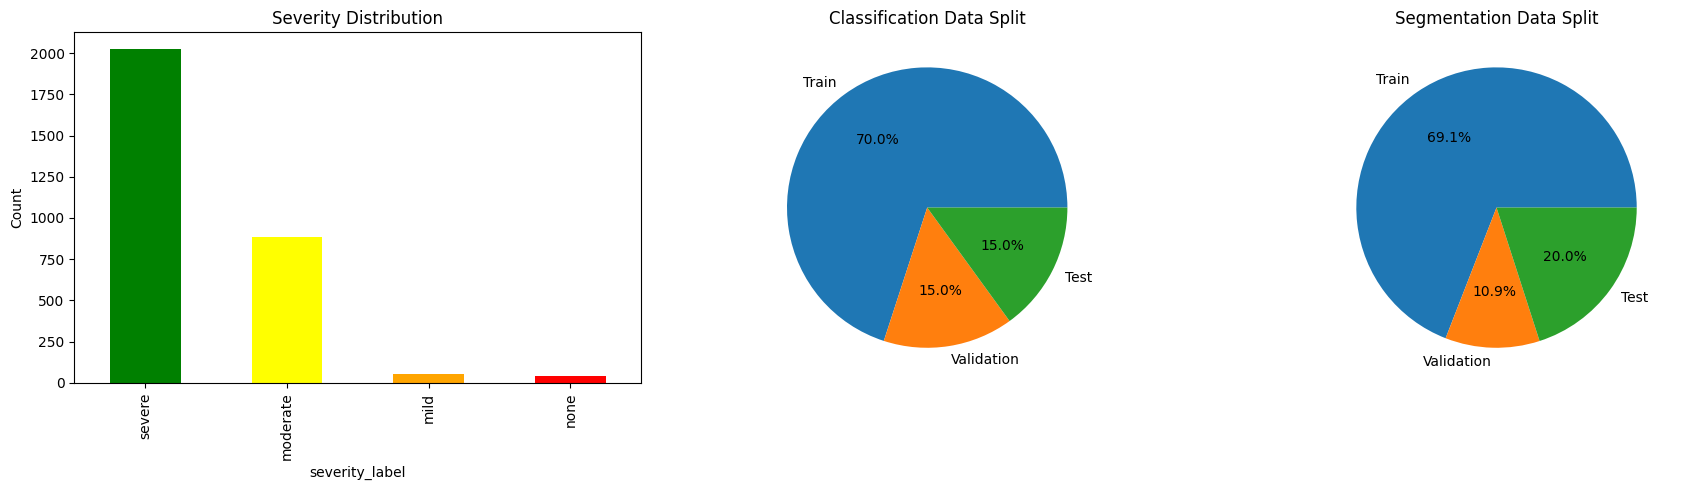


💾 Summary statistics saved to dataset_summary.json

🎉 DATA PREPARATION COMPLETE!


In [ ]:
# Create comprehensive dataset summary
print("📈 COMPREHENSIVE DATASET SUMMARY")
print("=" * 60)

# Use the ACTUAL integrated datasets we created above
class_df = diamos_classification  # Use full DiaMOS classification data
seg_df = pd.concat([plantseg_datasets['train'], plantseg_datasets['val'], plantseg_datasets['test']], ignore_index=True)

# Use the actual splits we created
class_train = diamos_train
class_val = diamos_val
class_test = diamos_test
seg_train = plantseg_datasets['train']
seg_val = plantseg_datasets['val']
seg_test = plantseg_datasets['test']

# Classification statistics - NOW USING FULL DATA
print("🎯 CLASSIFICATION DATA:")
severity_counts = class_df['severity_label'].value_counts()
print(severity_counts)

# Create visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Severity distribution
severity_counts.plot(kind='bar', ax=axes[0], color=['green', 'yellow', 'orange', 'red'])
axes[0].set_title('Severity Distribution')
axes[0].set_ylabel('Count')

# Train/Val/Test split visualization
split_data = {
    'Train': len(class_train),
    'Validation': len(class_val),
    'Test': len(class_test)
}
axes[1].pie(split_data.values(), labels=split_data.keys(), autopct='%1.1f%%')
axes[1].set_title('Classification Data Split')

# Segmentation data
seg_split_data = {
    'Train': len(seg_train),
    'Validation': len(seg_val),
    'Test': len(seg_test)
}
axes[2].pie(seg_split_data.values(), labels=seg_split_data.keys(), autopct='%1.1f%%')
axes[2].set_title('Segmentation Data Split')

plt.tight_layout()
plt.show()

# Create config_dict properly
config_dict = {
    'image_size': 512,
    'classification_classes': 4,
    'segmentation_classes': 2,
    'datasets_used': ['plantseg', 'diamos']
}

# Save summary statistics
summary_stats = {
    'classification': {
        'total_samples': len(class_df),
        'severity_distribution': severity_counts.to_dict(),
        'train_samples': len(class_train),
        'val_samples': len(class_val),
        'test_samples': len(class_test)
    },
    'segmentation': {
        'total_samples': len(seg_df),
        'train_samples': len(seg_train),
        'val_samples': len(seg_val),
        'test_samples': len(seg_test)
    },
    'config': config_dict
}

with open(METADATA_DIR / "dataset_summary.json", 'w') as f:
    json.dump(summary_stats, f, indent=2)

print(f"\n💾 Summary statistics saved to dataset_summary.json")

print(f"\n🎉 DATA PREPARATION COMPLETE!")
